In [1]:
%load_ext autoreload
%autoreload 2

# Import packages 

In [110]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
%matplotlib inline

# Load dataset and Explore it

In [3]:
sms_dataset = pd.read_csv("data/datasets_483_982_spam.csv", encoding = "ISO-8859-1")
sms_dataset_orig = sms_dataset

In [4]:
sms_dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
sms_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Rename columns 

In [6]:
sms_dataset.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [7]:
sms_dataset.columns = ["label", "message", "v2", "v3", "v4"]

In [8]:
sms_dataset.head()

,label,message,v2,v3,v4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Check abnormal columns

In [9]:
sms_dataset.v4.unique()

array([nan, ' just Keep-in-touch\\" gdeve.."', 'GNT:-)"',
       ' Never comfort me with a lie\\" gud ni8 and sweet dreams"',
       ' CALL 2MWEN IM BK FRMCLOUD 9! J X\\""',
       ' one day these two will become FREINDS FOREVER!"'], dtype=object)

In [10]:
sms_dataset.v3.unique()

array([nan, ' MK17 92H. 450Ppw 16"', ' why to miss them', 'GE',
       'U NO THECD ISV.IMPORTANT TOME 4 2MORO\\""',
       'i wil tolerat.bcs ur my someone..... But',
       ' ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\\""',
       'whoever is the KING\\"!... Gud nyt"', ' TX 4 FONIN HON',
       ' \\"OH No! COMPETITION\\". Who knew', 'IåÕL CALL U\\""'],
      dtype=object)

### Look at the repartition between ham and spam 

In [11]:
sms_dataset.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<class 'matplotlib.axes._subplots.AxesSubplot'>


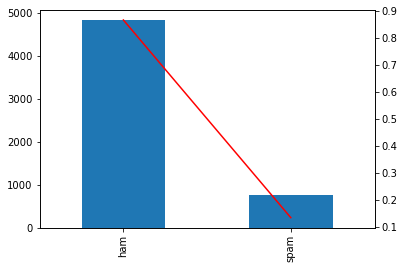

In [12]:
ax1 = sms_dataset.label.value_counts().plot.bar()
print(type(ax1))
ax2 = ax1.twinx()
sms_dataset.label.value_counts(normalize=True).plot.line(color = "red")


In [13]:
sms_dataset.groupby("label").describe()

message                                                                 \
        count unique                                                top freq   
label                                                                          
ham      4825   4516                             Sorry, I'll call later   30   
spam      747    653  Please call our customer service representativ...    4   

         v2                                                                 \
      count unique                                                top freq   
label                                                                        
ham      45     39   bt not his girlfrnd... G o o d n i g h t . . .@"    3   
spam      5      4                                        PO Box 5249    2   

         v3                                       v4                       
      count unique                    top freq count unique      top freq  
label                                                                      
ham      10      9                     GE    2     6      5  GNT:-)"    2  
spam      2      1   MK17 92H. 450Ppw 16"    2     0      0      NaN  NaN

# Transform and Pre-process dataset 

We will remove columns that we can't use and transform initial values in something that can be easiliy used by the algorithm.

In [14]:
sms_dataset = sms_dataset.iloc[:,:2]

In [15]:
sms_dataset['label'].head()

0     ham
1     ham
2    spam
3     ham
4     ham
Name: label, dtype: object

### Create boolean label column 

In [16]:
sms_dataset.loc[:,'true_label'] = sms_dataset.label.apply(lambda x: x == "spam")
sms_dataset.head()

e:\ProgramData\Anaconda3\envs\ds_37\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
e:\ProgramData\Anaconda3\envs\ds_37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,label,message,true_label
0,ham,"Go until jurong point, crazy.. Available only ...",False
1,ham,Ok lar... Joking wif u oni...,False
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True
3,ham,U dun say so early hor... U c already then say...,False
4,ham,"Nah I don't think he goes to usf, he lives aro...",False


# Split Data in training set and test set 

A good practice is to split the data set in 2 datasets. 

The first dataset will be used for learning and adjusting the parameters.

The second dataset will be kept aside for final evaluation once the algorithm is tuned.

In [17]:
sms_train = sms_dataset.sample(frac=0.7, random_state = 1234)
sms_test = sms_dataset.drop(sms_train.index)

In [18]:
sms_train.head()

,label,message,true_label
1537,ham,All sounds good. Fingers . Makes it difficult ...,False
963,ham,Yo chad which gymnastics class do you wanna ta...,False
4421,ham,MMM ... Fuck .... Merry Christmas to me,False
46,ham,Didn't you get hep b immunisation in nigeria.,False
581,ham,Ok anyway no need to change with what you said,False


In [19]:
sms_train.shape, sms_test.shape

((3900, 3), (1672, 3))

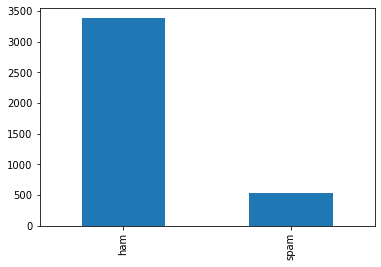

In [20]:
sms_train.label.value_counts().plot.bar()

### More advanced spliting technique 

In [82]:
sms_dataset = sms_dataset.drop(columns=['trad_label'])
sms_dataset_train, sms_dataset_test, labels_train, labels_test = train_test_split(sms_dataset, sms_dataset['label'], test_size=0.3, random_state=111)

In [83]:
sms_dataset_train.shape, sms_dataset_test.shape

((3900, 4), (1672, 4))

In [84]:
sms_dataset_test.index

Int64Index([2291, 3384, 1192, 1134, 1310, 2503, 2862, 5203, 5561, 4766,
            ...
            4429,  119,  863, 1607, 3264, 3283, 4054, 2756, 3471, 5337],
           dtype='int64', length=1672)

## Visualize the training dataset

You can change the number of messages displayed if you want to improve your accuracy

In [86]:
TICKETS_TO_DISPLAY = 20
sms_dataset_train.head(TICKETS_TO_DISPLAY)

,label,message,true_label,length
3466,spam,URGENT! We are trying to contact U. Todays dra...,True,157
3559,ham,Lol I know! Hey someone did a great inpersonat...,False,83
1657,ham,S:-)if we have one good partnership going we w...,False,61
110,ham,What is the plural of the noun research?,False,40
1010,ham,Lol I would but my mom would have a fit and te...,False,93
3877,ham,What you need. You have a person to give na.,False,44
2209,ham,"Hmm well, night night",False,22
5487,spam,2p per min to call Germany 08448350055 from yo...,True,145
4018,spam,U've been selected to stay in 1 of 250 top Bri...,True,159
2850,ham,Are you going to wipro interview today?,False,39


# Traditional approach : predict 

### Conditionnal function to modify

In [87]:
# Adapt the function below and add rules to predict 
# if the message is a spam or not
# returns True if the message is a spam
def trad_predict_label(message):
    if "€" in message:
        return True
    if "$" in message:
        return True
    if "£" in message:
        return True
    return False

In [88]:
trad_predict_label("test of sms"), trad_predict_label("test of € sms")

(False, True)

In [89]:
trad_predict_label(sms_dataset.message[0])

False

In [90]:
sms_dataset_test.message.apply(trad_predict_label).sum()

74

### Apply the function to every message

In [91]:
sms_dataset['trad_label'] = sms_dataset.message.apply(trad_predict_label)

### Define score  : Accuracy

In [92]:
accuracy_score(sms_dataset.true_label,sms_dataset.trad_label)

0.908829863603733

# Machine Learning approach #1 

In [28]:
sms_dataset['length'] = sms_dataset.message.apply(len)
sms_dataset.head()

,label,message,true_label,trad_label,length
0,ham,"Go until jurong point, crazy.. Available only ...",False,False,111
1,ham,Ok lar... Joking wif u oni...,False,False,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,True,False,155
3,ham,U dun say so early hor... U c already then say...,False,False,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",False,False,61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000255FA055D48>,
      dtype=object)

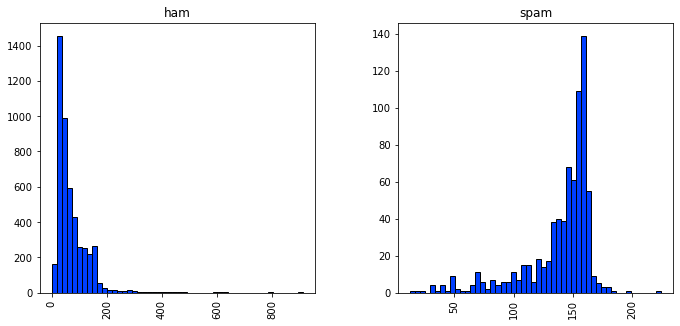

In [109]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms_dataset.hist(column='length', by='label', bins=50,figsize=(11,5))

## Pre-process the text and clean it

### remove punctuation or other special character

In [30]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [31]:
sms_messages = sms_dataset.message.copy()

In [34]:
sms_messages[0].translate(str.maketrans('', '', string.punctuation))

'Go until jurong point crazy Available only in bugis n great world la e buffet Cine there got amore wat'

Apply the transformation to every messages to remove punctuation

In [35]:
sms_messages_tf = sms_messages.apply(text_process)

### Transform the text in Matrix 

In [36]:
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(sms_messages_tf)

In [43]:
features.toarray()[0,:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
len(vectorizer.get_feature_names())

9376

In [50]:
vectorizer.get_feature_names()[1000:1010]

['ad',
 'adam',
 'add',
 'addamsfa',
 'added',
 'addicted',
 'addie',
 'adding',
 'address',
 'addressull']

## Classifiers and prediction 

### Split the dataset

In [52]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms_dataset['label'], test_size=0.3, random_state=111)

In [68]:
features_test.shape

(1672, 9376)

In [74]:
labels_test.index

Int64Index([2291, 3384, 1192, 1134, 1310, 2503, 2862, 5203, 5561, 4766,
            ...
            4429,  119,  863, 1607, 3264, 3283, 4054, 2756, 3471, 5337],
           dtype='int64', length=1672)

### Import and set the classifiers 

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [54]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Define a list of classifiers

In [55]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Iterate for each classifier

In [56]:
pred_scores = []
for k,v in clfs.items():
    v.fit(features_train, labels_train)
    pred = v.predict(features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [102]:
df['Score'].apply(lambda x: x[0])

0    0.978469
1    0.924641
2    0.984450
3    0.958732
4    0.943182
5    0.970096
6    0.967105
7    0.967105
8    0.977273
Name: Score, dtype: float64

In [103]:
df = pd.DataFrame(pred_scores, columns=['Classifier','Score'])
df['Score'] = df['Score'].apply(lambda x: x[0])
df

,Classifier,Score
0,SVC,0.978469
1,KN,0.924641
2,NB,0.984450
3,DT,0.958732
4,LR,0.943182
5,RF,0.970096
6,AdaBoost,0.967105
7,BgC,0.967105
8,ETC,0.977273


Text(0.5, 1.0, 'Distribution by Classifier')

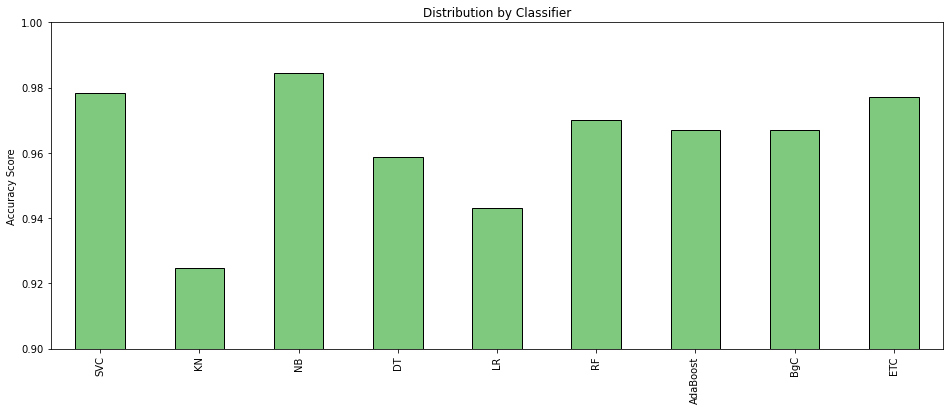

In [112]:
df.Score.plot.bar(ylim= (0.9, 1.0),figsize=(16, 6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df['Classifier'])
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')

# Machine Learning approach #2 (with feature engeeniring ) 

1. Use stemming or Lemming on text
1. Use length of the message

https://www.kaggle.com/muzzzdy/sms-spam-detection-with-various-classifiers